<a href="https://colab.research.google.com/github/RajidiSahithi/SahithiR_ERA_Session7/blob/main/Model_1_S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Target:**
1.   Get the set-up right
2.   Set Transforms
3.   Set Data Loader
4.   Set Basic Working Code
5.    Set Basic Training  & Test Loop
6.   Skeleton of CNN model is fixed as Squeeze Expand / Chirstmastree model

# **Result:**


1.   Parameters: 18,344
2.  Best Training Accuracy: 99.31
3. Best Test Accuracy: 98.75



# **Analysis:**

1.   More Number of Parameters than requirment ( less than 8000)
2.   A Random model is taken and the images are observed to find out which trasformation to apply on the data. (Here we can apply rotation). Rotation will be applied once the model is set.
3. It is observed that the model is underfitting in the initial epochs. We cant say it as underfitting in the initial epochs training starts with random values so iraining accuracy will be less.
4. Later after few epochs on it is observed that the model is overfitting ( If the performance on the validation set starts to decrease while the performance on the training set continues to improve, then the model is likely overfitting). we can observe overfitting from epoch=5
5. The skeleton is set
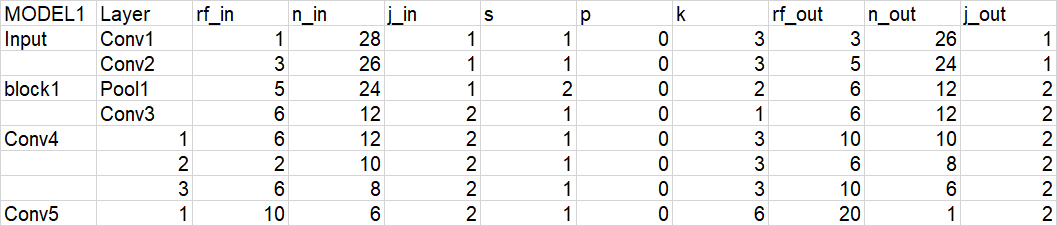
5. To further increse accuracy we shall add batch normalization and regularization, GAP to reduce number of parameters.

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Python code snippet

Imports PyTorch’s neural network module
torch.nn and other PyTorch modules such as torch.optim, torch.nn.functional, and torchvision.datasets.


*   The torch.nn module provides classes for defining and training neural networks. It includes layers such as linear layers, convolutional layers, and recurrent layers that can be used to define the architecture of a neural network.
*   The torch.optim module provides optimization algorithms such as stochastic gradient descent (SGD) that can be used to train the neural network.


*   The torch.nn.functional module provides functions that can be used to define the loss function of the neural network.
*   The torchvision.datasets module provides datasets such as MNIST that can be used for training and testing the neural network.

In [ ]:
#one time operations on CPU so used numpy
#This block is used to obtain mean and variance
simple_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

100%|██████████| 9912422/9912422 [00:00<00:00, 85826107.30it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41484826.65it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28357298.54it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21477484.52it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
#downloading train and test data
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
len(train),len(test)

(60000, 10000)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#(number of workers=no of CPU)-1
# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


torch.Size([128, 1, 28, 28])
torch.Size([128])


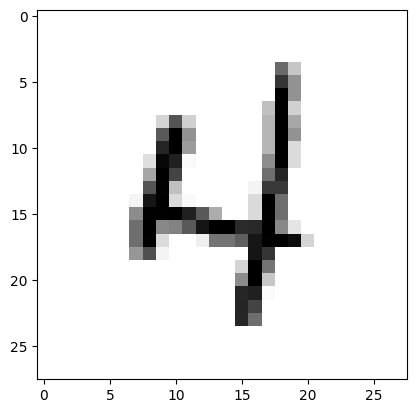

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

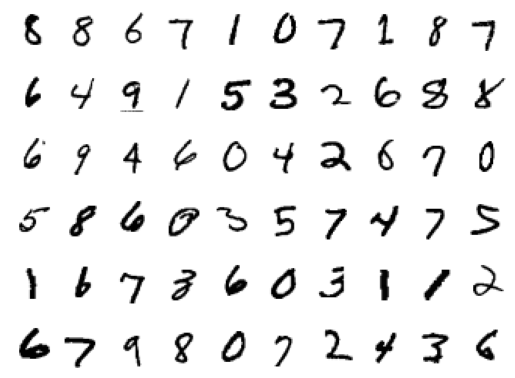

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    #INPUT BLOCK
    self.conv1= self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )
    #CONVOLUTIONAL BLOCK 1
    self.conv2=nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )
    self.maxpool1=nn.MaxPool2d(2,2)
    #TRANSITION BLOCK 1 using kernal size 1 X 1 (Antman)
    self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        )
    # CONVOLUTION BLOCK 2
    self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        )
    #self.maxpool2=nn.MaxPool2d(2,2)

    # CONVOLUTIONAL BLOCK
    self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(6, 6), padding=0, bias=False),

        )

  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.maxpool1(x)
      x = self.conv3(x)
      x = self.conv4(x)
      #x = self.maxpool2(x)
      x = self.conv5(x)
      x = x.view(-1, 16)
      return F.log_softmax(x,dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
         MaxPool2d-5           [-1, 16, 12, 12]               0
            Conv2d-6            [-1, 8, 12, 12]             128
              ReLU-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 12, 10, 10]             864
              ReLU-9           [-1, 12, 10, 10]               0
           Conv2d-10             [-1, 16, 8, 8]           1,728
             ReLU-11             [-1, 16, 8, 8]               0
           Conv2d-12             [-1, 20, 6, 6]           2,880

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    #traing acc<test acc is overfitting and viceversa is underfitting
    #diff b/w traing and test acc increases ---------- it causes overfitting

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.09303175657987595 Batch_id=468 Accuracy=80.08: 100%|██████████| 469/469 [00:26<00:00, 17.80it/s]



Test set: Average loss: 0.1118, Accuracy: 9659/10000 (96.59%)

EPOCH: 1


Loss=0.12916623055934906 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]



Test set: Average loss: 0.0711, Accuracy: 9761/10000 (97.61%)

EPOCH: 2


Loss=0.14786772429943085 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]



Test set: Average loss: 0.0582, Accuracy: 9805/10000 (98.05%)

EPOCH: 3


Loss=0.03568464517593384 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]



Test set: Average loss: 0.0564, Accuracy: 9815/10000 (98.15%)

EPOCH: 4


Loss=0.09428280591964722 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]



Test set: Average loss: 0.0537, Accuracy: 9822/10000 (98.22%)

EPOCH: 5


Loss=0.0293632373213768 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:18<00:00, 25.89it/s]



Test set: Average loss: 0.0490, Accuracy: 9847/10000 (98.47%)

EPOCH: 6


Loss=0.03560953214764595 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:16<00:00, 27.97it/s]



Test set: Average loss: 0.0503, Accuracy: 9835/10000 (98.35%)

EPOCH: 7


Loss=0.007433359045535326 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]



Test set: Average loss: 0.0488, Accuracy: 9843/10000 (98.43%)

EPOCH: 8


Loss=0.026374822482466698 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]



Test set: Average loss: 0.0441, Accuracy: 9872/10000 (98.72%)

EPOCH: 9


Loss=0.0631740614771843 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 29.18it/s]



Test set: Average loss: 0.0448, Accuracy: 9857/10000 (98.57%)

EPOCH: 10


Loss=0.006839970592409372 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 28.54it/s]



Test set: Average loss: 0.0604, Accuracy: 9821/10000 (98.21%)

EPOCH: 11


Loss=0.07408168166875839 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]



Test set: Average loss: 0.0486, Accuracy: 9852/10000 (98.52%)

EPOCH: 12


Loss=0.0015610778937116265 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]



Test set: Average loss: 0.0492, Accuracy: 9838/10000 (98.38%)

EPOCH: 13


Loss=0.03564969077706337 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]



Test set: Average loss: 0.0452, Accuracy: 9870/10000 (98.70%)

EPOCH: 14


Loss=0.005776574835181236 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]



Test set: Average loss: 0.0513, Accuracy: 9854/10000 (98.54%)



In [ ]:
train_losses

[tensor(2.7743, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7736, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7730, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7733, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7732, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7742, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7727, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7730, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7730, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7724, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7723, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7714, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7715, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7710, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7705, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.7699, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

In [ ]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

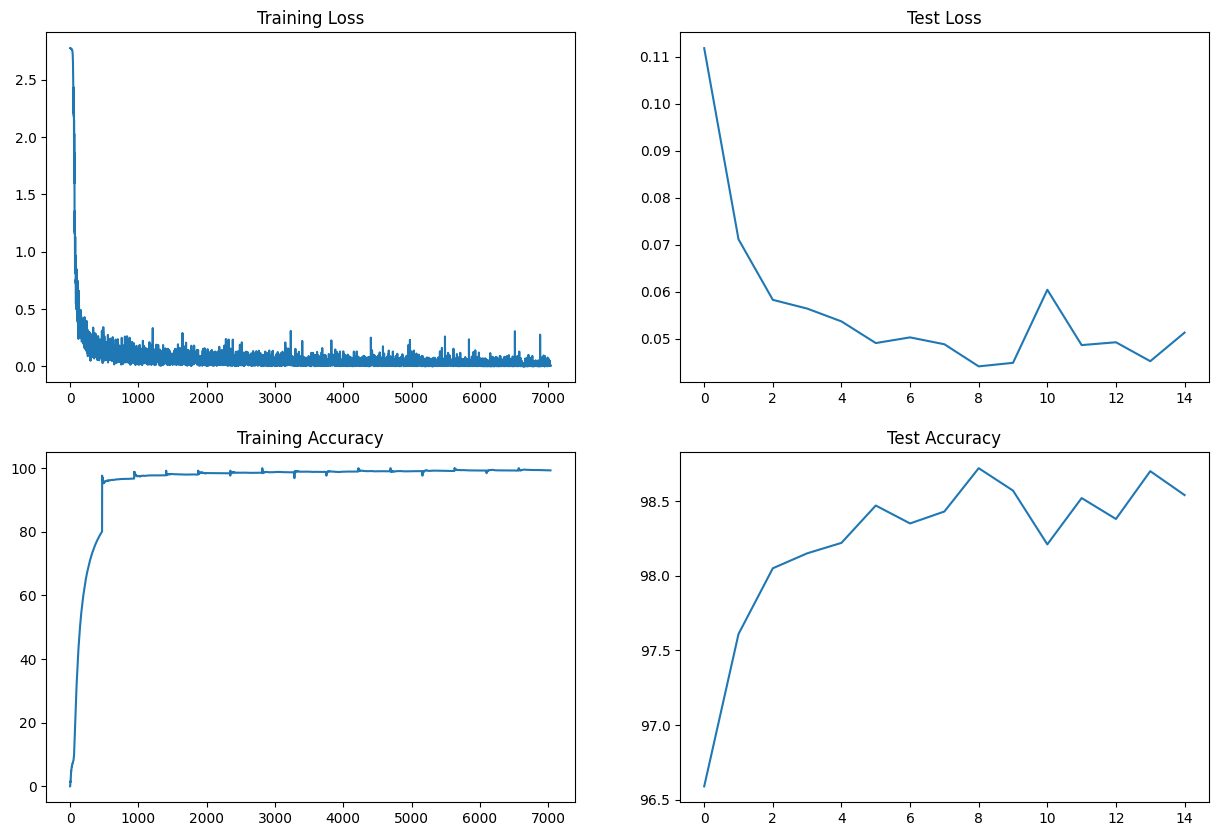

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")